# Technology focus: 10x Genomics Visium (Spatial Transcriptomics)
This notebook will present a rough overview of the plotting functionalities that `spatialdata` implements for Visium data.

## Loading the data
Please download the data from here: [Visium dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/visium.zarr/) and adjust the variable containing the location of the `.zarr` file.


In [3]:
visium_zarr_path = "/Users/tim.treis/Documents/GitHub/spatialdata-sandbox/visium/data.zarr"

In [7]:
import spatialdata as sd

visium_sdata = sd.read_zarr(visium_zarr_path)
visium_sdata

/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


SpatialData object with:
├── Images
│     ├── 'ST8059050_image': SpatialImage[cyx] (3, 2000, 1968)
│     └── 'ST8059051_image': SpatialImage[cyx] (3, 2000, 1963)
├── Shapes
│     ├── 'ST8059050_shapes': GeoDataFrame shape: (3497, 2) (2D shapes)
│     └── 'ST8059051_shapes': GeoDataFrame shape: (2409, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 5906 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'annotating', 'library', 'spot_id'
    uns: 'spatialdata_attrs': AnnData (5906, 31053)
with coordinate systems:
▸ 'ST8059050', with elements:
        ST8059050_image (Images), ST8059050_shapes (Shapes)
▸ 'ST8059051', with elements:
        ST8059051_image (Images), ST8059051_shapes (Shapes)

## Visualise the data
We're going to create a naiive visualisation of the data, overlaying the Visium spots and the tissue images. For this, we need to load the `spatialdata_plot` library which extends the `sd.SpatialData` object with the `.pl` module. 

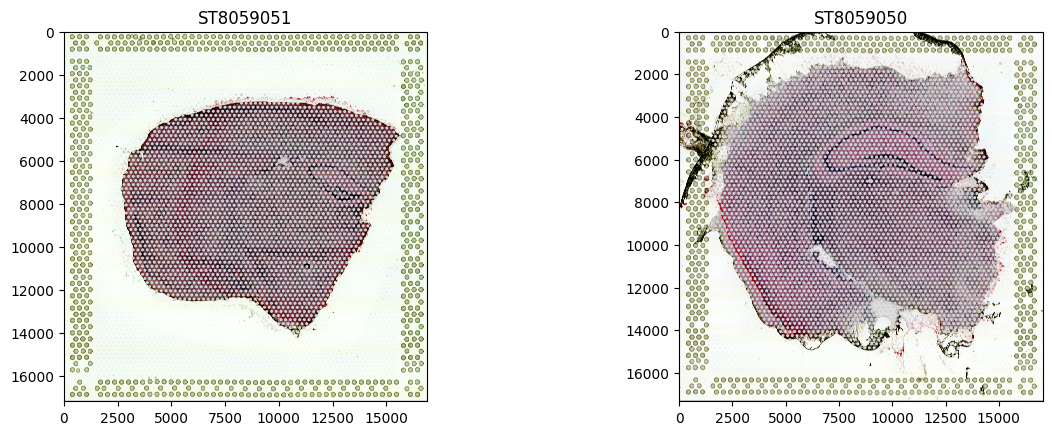

In [8]:
import spatialdata_plot

(
    visium_sdata
    .pl.render_images()
    .pl.render_shapes()
    .pl.show()
)

We can see that the data contains two coordinate systems (`ST8059050` and `ST8059051`) with image and spot information each. In `SpatialData`, these spots are represented as `Shapes`. When giving no further parameters, one panel is generated per coordinate system with the members that have been specified in the function call. We can see that the spots are aligned to the tissue representation which is also respected by the plotting logic.

However, the spots are all grey since we have not provided any information on what they should encode. Such information can be found in the `Table` attribute (which is an `anndata.AnnData` table) of the `SpatialData` object. Such information can be contained either in the data itself or the `obs` attribute.

In [30]:
visium_sdata.table.to_df().head(3)
# We will use the gene "mt-Co3" since it has a highly variable expression across the tissue slice 

,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,Tcea1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
AAACCGGGTAGGTACC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
visium_sdata.table.obs.head(3)

,in_tissue,array_row,array_col,annotating,library,spot_id
AAACAAGTATCTCCCA-1,1,50,102,ST8059051_shapes,ST8059051,0
AAACAGAGCGACTCCT-1,1,14,94,ST8059051_shapes,ST8059051,1
AAACCGGGTAGGTACC-1,1,42,28,ST8059051_shapes,ST8059051,2


In [35]:
visium_sdata.table.to_df().sum(axis=0).sort_values().index

Index(['Gm11378', '2610204G07Rik', 'Gm5930', 'Gm17160', 'Gm8229', 'Gm3371',
       '1700099I09Rik', 'Ccin', 'Gm12493', 'AC242269.1',
       ...
       'Fth1', 'Ttr', 'mt-Nd2', 'mt-Nd1', 'mt-Nd4', 'mt-Cytb', 'mt-Co2',
       'mt-Atp6', 'mt-Co1', 'mt-Co3'],
      dtype='object', length=31053)

### Color the visium spots by gene expression
To use this information in our plot, we provide information on which columns in the data identify each spot (`spot_id`) as the `groups` and which column to use for the color-encoding values `color` to `render_shapes()`. Furthermore, we are going to subset the data to only one coordinate system.

/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


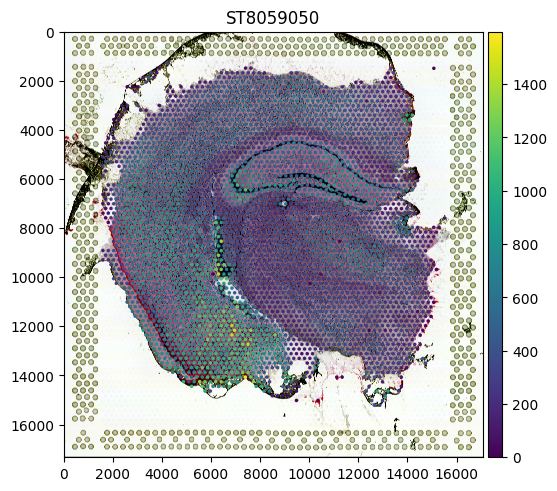

In [29]:
(
    visium_sdata
    .pp.get_elements("ST8059050")
    .pl.render_images()
    .pl.render_shapes(groups="spot_id", color="mt-Co3")
    .pl.show()
)


We can also provide `ax` objects to `spatialdata_plot` for further customisation.

/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


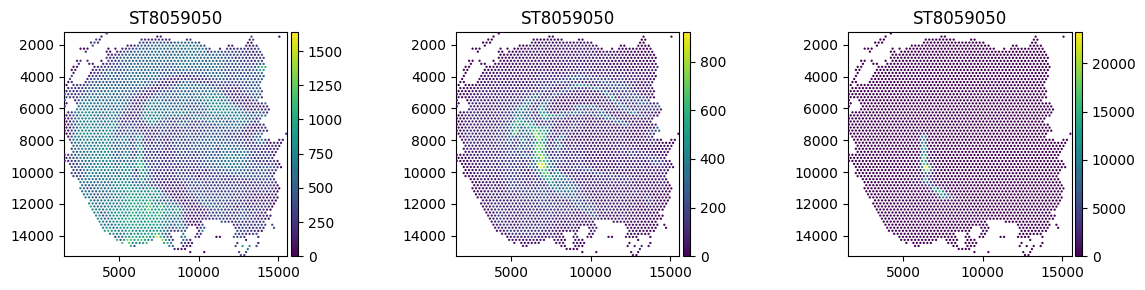

In [40]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,3))

visium_sdata_subset = visium_sdata.pp.get_elements("ST8059050")

(
    visium_sdata_subset
    .pl.render_shapes(groups="spot_id", color="mt-Co1")
    .pl.show(ax=axs[0])
)

(
    visium_sdata_subset
    .pl.render_shapes(groups="spot_id", color="Fth1")
    .pl.show(ax=axs[1])
)

(
    visium_sdata_subset
    .pl.render_shapes(groups="spot_id", color="Ttr")
    .pl.show(ax=axs[2])
)

plt.tight_layout()